In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
import bert_utils

import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import time

from transformers import BertTokenizer, BertModel, XLNetTokenizer, XLNetModel 
pretrained_model = BertModel.from_pretrained('bert-base-chinese')
# https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-pytorch_model.bin
tokenizer =BertTokenizer.from_pretrained('bert-base-chinese')
#model_bert = BertModel.from_pretrained('bert-base-uncased')

In [5]:
from pytorch_transformers.modeling_bert import BertForSequenceClassification, BertConfig
help(BertForSequenceClassification)

Help on class BertForSequenceClassification in module pytorch_transformers.modeling_bert:

class BertForSequenceClassification(BertPreTrainedModel)
 |  BertForSequenceClassification(config)
 |  
 |  Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of
 |  the pooled output) e.g. for GLUE tasks.     The BERT model was proposed in
 |  `BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding`_
 |  by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. It's a bidirectional transformer
 |  pre-trained using a combination of masked language modeling objective and next sentence prediction
 |  on a large corpus comprising the Toronto Book Corpus and Wikipedia.
 |  
 |  This model is a PyTorch `torch.nn.Module`_ sub-class. Use it as a regular PyTorch Module and
 |  refer to the PyTorch documentation for all matter related to general usage and behavior.
 |  
 |  .. _`BERT: Pre-training of Deep Bidirectional T

In [163]:
import os
import numpy as np
ids = np.load('kfold/test_ids.npy')
results =[]
datanames = os.listdir('kfold/')
for dataname in datanames:
    if 'LSTM' in dataname:
        results.append(np.load('kfold/'+dataname))
print(len(results))
average = np.average(results,axis=0)
preds = np.argmax(average,axis=1) 
dic =[-1,0,1]
result = [dic[i] for i in preds]
test=pd.DataFrame(result,index=ids,columns=['y'])
test.to_csv('kfold/result_5.csv')

5


In [2]:
import pandas as pd
import numpy as np
train_label_path = "data/train_label.csv"
train_unlabel_path = "data/train_unlabel.csv"
test_path ="data/test.csv"
def get_data():
    train_data = pd.read_csv(train_label_path)
    #print('train_origin shape=',train_data.shape)
    test_data = pd.read_csv(test_path)
    train_data = train_data[train_data['情感倾向'].isin(['-1','0','1'])]  #去除标签错误的
    labels = np.asarray(train_data['情感倾向'].astype(int)+1)
    #print('train_shape=',train_data.shape)
    return train_data['微博中文内容'].values,labels,test_data['微博中文内容'].values,test_data['微博id'].values
train,labels,test,ids = get_data()
unlabel_data = pd.read_csv(train_unlabel_path)

In [6]:
import torch
import torch.nn as nn
#help(nn.LSTM)
pretrained_model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "

In [7]:
import heapq
help(heapq)

Help on module heapq:

NAME
    heapq - Heap queue algorithm (a.k.a. priority queue).

MODULE REFERENCE
    https://docs.python.org/3.7/library/heapq
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    Heaps are arrays for which a[k] <= a[2*k+1] and a[k] <= a[2*k+2] for
    all k, counting elements from 0.  For the sake of comparison,
    non-existing elements are considered to be infinite.  The interesting
    property of a heap is that a[0] is always its smallest element.
    
    Usage:
    
    heap = []            # creates an empty heap
    heappush(heap, item) # pushes a new item on the heap
    item = heappop(heap) # pops the smallest item from the heap
    item = heap[0]       # smallest item

In [157]:
xtrain,xvalid,ytrain,yvalid,test_data,ids = bert_utils.get_Bert_data()

微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频,情感倾向
Finish read File len:99317,unlabel:86 no_text：597
微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频
Finish read File len:10000,unlabel:0 no_text：64
train_data:89385,valid_data:9932,test_data:10000


In [ ]:
def re_save_file(path,write_path):
    with open(path,'r',encoding='gbk',errors='ignore') as f:
        with open(write_path,'w',encoding='utf-8') as wf:
            for line in f:
                wf.write(line)
re_save_file(train_label_path,'data/train_label.csv')
re_save_file(train_unlabel_path,'data/train_unlabel.csv')
re_save_file(test_path,'data/test.csv')

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)
train_data = pd.read_csv('data/train_label.csv')
test_data =pd.read_csv('data/test.csv')

In [117]:
train_data = train_data.dropna(axis=0,subset=['微博中文内容','情感倾向'])
print(train_data.info())
print(train_data['情感倾向'].value_counts())
#train_data = train_data.loc[train_data['情感倾向']=='0']
train_data = train_data[train_data['情感倾向'].isin(['-1','0','1'])]
print(train_data.info())
print(train_data['情感倾向'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99566 entries, 0 to 99999
Data columns (total 7 columns):
微博id      99566 non-null int64
微博发布时间    99566 non-null object
发布人账号     99566 non-null object
微博中文内容    99566 non-null object
微博图片      99566 non-null object
微博视频      99566 non-null object
情感倾向      99566 non-null object
dtypes: int64(1), object(6)
memory usage: 6.1+ MB
None
0     57287
1     25374
-1    16899
-         1
·         1
9         1
10        1
4         1
-2        1
Name: 情感倾向, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99560 entries, 0 to 99999
Data columns (total 7 columns):
微博id      99560 non-null int64
微博发布时间    99560 non-null object
发布人账号     99560 non-null object
微博中文内容    99560 non-null object
微博图片      99560 non-null object
微博视频      99560 non-null object
情感倾向      99560 non-null object
dtypes: int64(1), object(6)
memory usage: 6.1+ MB
None
0     57287
1     25374
-1    16899
Name: 情感倾向, dtype: int64


In [144]:
df = pd.DataFrame([[2], [4, 5], [7, 8]],
    index=['1', '2', '3'],
     columns=['A', 'B'])
df['A']['1'] =10
print(df)
print(df.fillna(''))
print(df)
np.array(df['A'])

    A    B
1  10  NaN
2   4  5.0
3   7  8.0
    A  B
1  10   
2   4  5
3   7  8
    A    B
1  10  NaN
2   4  5.0
3   7  8.0


/home/zht/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([10,  4,  7])

In [93]:
train_data.info()
test_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
微博id       100000 non-null int64
微博发布时间     100000 non-null object
发布人账号      100000 non-null object
微博中文内容     99646 non-null object
微博图片       100000 non-null object
微博视频       100000 non-null object
情感倾向       99919 non-null object
time       100000 non-null datetime64[ns]
day_num    100000 non-null int64
hour       100000 non-null int64
len        100000 non-null int64
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 8.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
微博id      10000 non-null int64
微博发布时间    10000 non-null object
发布人账号     10000 non-null object
微博中文内容    9963 non-null object
微博图片      10000 non-null object
微博视频      10000 non-null object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


,微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频,情感倾向,time,day_num,hour,len
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0,1900-01-01 23:50:00,1,23,147
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1,1900-01-01 23:58:00,1,23,47
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,偳癯空饩褪俏业，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1g...,[],1,1900-01-01 22:39:00,1,22,98
3,4456061509126470,01月01日 23:08,芩鎟,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,['https://ww2.sinaimg.cn/orj360/005FL9LZgy1gah...,[],1,1900-01-01 23:08:00,1,23,30
4,4455979322528190,01月01日 17:42,changlwj,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,[],[],1,1900-01-01 17:42:00,1,17,145


In [140]:
type(train_data['微博中文内容'])

pandas.core.series.Series

In [43]:
train_data['情感倾向'].value_counts()

0     57619
1     25392
-1    16902
-         1
·         1
9         1
10        1
4         1
-2        1
Name: 情感倾向, dtype: int64

In [58]:
train_data['time'] = pd.to_datetime(train_data['微博发布时间'],format='%m月%d日  %H:%M')

In [59]:
train_data['time'].dt.month.value_counts()

2    51805
1    48195
Name: time, dtype: int64

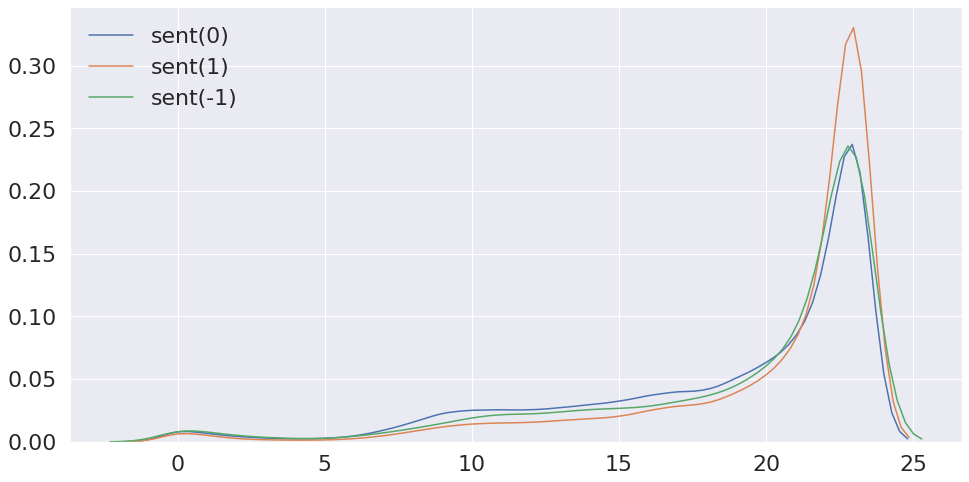

In [71]:
train_data['day_num'] = (train_data['time'].dt.month -1) *31 + train_data['time'].dt.day
train_data['day_num'].value_counts(sort=False) 
train_data['time'].dt.hour.value_counts()
train_data['hour'] = train_data['time'].dt.hour

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.kdeplot(train_data.loc[train_data['情感倾向']=='0','hour'],ax=ax,label='sent(0)')
sns.kdeplot(train_data.loc[train_data['情感倾向']=='1','hour'],ax=ax,label='sent(1)')
sns.kdeplot(train_data.loc[train_data['情感倾向']=='-1','hour'],ax=ax,label='sent(-1)')

#print(train_data.loc[train_data['情感倾向']=='0','hour'].value_counts())
#print(train_data.loc[train_data['情感倾向']=='1','hour'].value_counts())
#print(train_data.loc[train_data['情感倾向']=='-1','hour'].value_counts())

In [84]:
train_data['len'] = train_data['微博中文内容'].astype(str).apply(len)
print(len(train_data.loc[train_data['len']<=50]))
print(len(train_data.loc[train_data['len']<=100]))
print(len(train_data.loc[train_data['len']<=150]))
print(len(train_data.loc[train_data['len']<=200]))
print(len(train_data.loc[train_data['len']>200]))
#type(train_data['len'][0])

30819
56451
93473
99975
25


In [85]:
from sklearn.model_selection import StratifiedKFold
help(StratifiedKFold)

Help on class StratifiedKFold in module sklearn.model_selection._split:

class StratifiedKFold(_BaseKFold)
 |  StratifiedKFold(n_splits='warn', shuffle=False, random_state=None)
 |  
 |  Stratified K-Folds cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets.
 |  
 |  This cross-validation object is a variation of KFold that returns
 |  stratified folds. The folds are made by preserving the percentage of
 |  samples for each class.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=3
 |      Number of folds. Must be at least 2.
 |  
 |      .. versionchanged:: 0.20
 |          ``n_splits`` default value will change from 3 to 5 in v0.22.
 |  
 |  shuffle : boolean, optional
 |      Whether to shuffle each class's samples before splitting into batches.
 |  
 |  random_state : int, RandomState instance or None, optional, default=None
 |      If int, random_state is the seed used by

In [122]:
from sklearn.linear_model import LogisticRegression
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag', 's